# OVERVIEW
In the National Football League, coaches employ a variety of guiding philosophies that they believe are superior, proven pathways to consistent success. These days, much attention has been directed at the explosive offenses of the Los Angeles Rams and the Kansas City Chiefs, two teams who score very quickly while also surrendering a lot of points on defense. Some pundits and NFL veterans argue that this is the future of the league.

However, one approach that is getting overlooked is the maximization of "offensive efficiency." For this analysis, we'll define "offensive efficiency" as:

> <i>"Scoring the most points possible while prolonging possession of the ball in order to limit the opponent's possession of the ball."</i>

Teams that are highly offensive efficient therefore demonstrate the following traits:

- More plays per drive (offensive possession)
- More yards per drive
- Longer time of possession
- And obviously, more points per drive

Unlike the Chiefs, who often score touchdowns on a few large-yardage plays per drive, the 2018 New Orleans Saints rarely registered explosive plays that resulted in 40+ yards gained. Most of their plays were for short and intermediate yard gains that sustained drives that ultimately ended in a score. We'll explore the relationship beteen this approach and success.

### Comfortable Lead and Offensive Efficiency
We'll also look at how playoff-worthy teams perform once they've established a comfortable lead of 20+ points. Once a team establishes a comfortable lead, the team is expected to employ a strategy of "draining the clock" by calling more plays that are likely to prevent a play clock stoppage at the conclusion of the play. This is thus time for the leading team to demonstrate greater <i>offensive efficiency</i>.

By draining the clock and "slowing down the game", the team with the comfortable lead:

- Sustains longer offensive drives
- Makes the trailing team's defense tired, as the unit is on the field longer
- Limits the time the trailing team can play on offense
- Allows its defense to rest remain and 'fresh' for when it must take the field

Let's first read in our data.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('NFL Play by Play 2009-2018 (v5).csv', low_memory=False)

### Preliminary Feature Drop

Having read in our data and looking at the dataframe, we can immediately identify several features that serve no purpose for our analysis. Any feature pertaining to "expected points" or "probability" is a predictor of victory, additional points, additional yards gained, etc. using calculation methods we do not know. As we do not know how these were calculated, they are not useful and can thus be dropped.

In [2]:
columns_to_drop = ['no_score_prob', 'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob', 'fg_prob', 'safety_prob', 'td_prob', 
                   'extra_point_prob', 'two_point_conversion_prob', 'ep', 'epa', 'total_home_epa', 'total_away_epa',
                   'total_home_rush_epa', 'total_away_rush_epa', 'total_home_pass_epa', 'total_away_pass_epa', 'air_epa',
                   'yac_epa', 'comp_air_epa', 'comp_yac_epa', 'total_home_comp_air_epa','total_away_comp_air_epa',
                   'total_home_comp_yac_epa', 'total_away_comp_yac_epa', 'total_home_raw_air_epa',
                   'total_away_raw_air_epa','total_home_raw_yac_epa', 'total_away_raw_yac_epa', 'wp', 'def_wp',
                   'home_wp', 'away_wp', 'wpa', 'home_wp_post', 'away_wp_post','total_home_rush_wpa', 
                   'total_away_rush_wpa', 'total_home_pass_wpa', 'total_away_pass_wpa','air_wpa', 'yac_wpa',
                   'comp_air_wpa','comp_yac_wpa', 'total_home_comp_air_wpa', 'total_away_comp_air_wpa',
                   'total_home_comp_yac_wpa', 'total_away_comp_yac_wpa', 'total_home_raw_air_wpa', 'total_away_raw_air_wpa',
                   'total_home_raw_yac_wpa', 'total_away_raw_yac_wpa']

data = data.drop(columns_to_drop, axis=1)

We can also delete other features that pertain to specify individual players' involvement in plays (e.g. who recovered a fumble). As we're investigating the relationship between maintaining a comfortable lead and victory, these features are not pertinent. They can also be dropped.

In [3]:
drop = ['defteam','side_of_field','yardline_100','quarter_seconds_remaining','half_seconds_remaining',
 'quarter_end', 'sp', 'goal_to_go', 'time','yrdln','ydstogo','ydsnet','shotgun',
 'no_huddle','qb_dropback','qb_kneel','qb_spike','qb_scramble','pass_length','pass_location','air_yards','yards_after_catch',
 'run_location','run_gap','field_goal_result','kick_distance','extra_point_result',
 'two_point_conv_result','home_timeouts_remaining','away_timeouts_remaining','timeout_team','td_team',
 'posteam_timeouts_remaining','defteam_timeouts_remaining','punt_blocked','first_down_rush','first_down_pass',
 'first_down_penalty','third_down_failed','fourth_down_failed','punt_inside_twenty','punt_in_endzone','punt_out_of_bounds',
 'punt_downed','punt_fair_catch','kickoff_inside_twenty','kickoff_in_endzone','kickoff_out_of_bounds','kickoff_downed',
 'kickoff_fair_catch','fumble_forced','fumble_not_forced','fumble_out_of_bounds','solo_tackle','safety','tackled_for_loss',
 'fumble_lost','own_kickoff_recovery','own_kickoff_recovery_td','qb_hit','rush_attempt','pass_attempt','sack',
 'touchdown','pass_touchdown','rush_touchdown','return_touchdown','extra_point_attempt','two_point_attempt',
 'field_goal_attempt','kickoff_attempt','punt_attempt','fumble','complete_pass','assist_tackle','lateral_reception',
 'lateral_rush','lateral_return','lateral_recovery','passer_player_id','passer_player_name','receiver_player_id',
 'receiver_player_name','rusher_player_id','rusher_player_name','lateral_receiver_player_id','lateral_receiver_player_name',
 'lateral_rusher_player_id','lateral_rusher_player_name','lateral_sack_player_id','lateral_sack_player_name',
 'interception_player_id','interception_player_name','lateral_interception_player_id','lateral_interception_player_name',
 'punt_returner_player_id','punt_returner_player_name','lateral_punt_returner_player_id','lateral_punt_returner_player_name',
 'kickoff_returner_player_name','kickoff_returner_player_id','lateral_kickoff_returner_player_id',
 'lateral_kickoff_returner_player_name','punter_player_id','punter_player_name','kicker_player_name','kicker_player_id',
 'own_kickoff_recovery_player_id','own_kickoff_recovery_player_name','blocked_player_id','blocked_player_name',
 'tackle_for_loss_1_player_id','tackle_for_loss_1_player_name','tackle_for_loss_2_player_id','tackle_for_loss_2_player_name',
 'qb_hit_1_player_id','qb_hit_1_player_name','qb_hit_2_player_id','qb_hit_2_player_name','forced_fumble_player_1_team',
 'forced_fumble_player_1_player_id','forced_fumble_player_1_player_name','forced_fumble_player_2_team',
 'forced_fumble_player_2_player_id','forced_fumble_player_2_player_name','solo_tackle_1_team','solo_tackle_2_team',
 'solo_tackle_1_player_id','solo_tackle_2_player_id','solo_tackle_1_player_name','solo_tackle_2_player_name',
 'assist_tackle_1_player_id','assist_tackle_1_player_name','assist_tackle_1_team','assist_tackle_2_player_id',
 'assist_tackle_2_player_name','assist_tackle_2_team','assist_tackle_3_player_id','assist_tackle_3_player_name',
 'assist_tackle_3_team','assist_tackle_4_player_id','assist_tackle_4_player_name','assist_tackle_4_team',
 'pass_defense_1_player_id','pass_defense_1_player_name','pass_defense_2_player_id','pass_defense_2_player_name',
 'fumbled_1_team','fumbled_1_player_id','fumbled_1_player_name','fumbled_2_player_id','fumbled_2_player_name',
 'fumbled_2_team','fumble_recovery_1_team','fumble_recovery_1_yards','fumble_recovery_1_player_id',
 'fumble_recovery_1_player_name','fumble_recovery_2_team','fumble_recovery_2_yards','fumble_recovery_2_player_id',
 'fumble_recovery_2_player_name','return_team','return_yards','replay_or_challenge',
 'defensive_two_point_attempt','defensive_two_point_conv','defensive_extra_point_attempt','defensive_extra_point_conv']

data = data.drop(drop, axis=1)

# DATA EXPLORATION
Now, let's see how many games this dataset covers in order to get an idea of how representative this dataset is.

In [4]:
end_of_game = data[data['desc'] == 'END GAME']
end_of_game.shape

(2104, 35)

From a cursory look at the dataset, it appears that 'END GAME' in the 'desc' column is a reliable indicator of a game end. However, running end_of_game.shape shows that only 2104 games contain the 'END GAME' value. With 32 NFL teams each playing 16 games in a regular season, 256 games across all teams are played in a regular season. 2104/256 = ~8.2 seasons, suggesting that 'END GAME' does not capture all the game results.

In [5]:
end_of_game = data.sort_values('play_id').groupby('game_id').tail(1)
end_of_game.shape

(2526, 35)

We can see that this approach yields 2,526 games. Looking at the tail, it seems the last game captured in this data set is the Monday Night Football contest featuring the New Orlean Saints at the Carolina Panthers on December 17, 2018. This was the final game played in Week 15, meaning there were 32 games left to be played in the 2018 season (16 each in Weeks 16 and 17).

2,560 (10 complete seasons) - 2,526 = 34. This suggests that the dataset is missing 2 games. As this is a negligible amount, we can proceed with our analysis using nearly a decade's worth of data.

# FEATURE ENGINEERING

To more fully test our hypothesis, we need to create several new features that are currently not captured in the dataset. We'd like to know the following for each team on a cumulative (not per-play) basis:

- The number of run plays called
- The number of pass plays called
- The number of "chunk yardage" plays (plays that result in yardage gains of 10 to 25 yards)
- Time of possession

### Yardage Clean-up
The first feature we should investigate is the yardage accrued on each play. This can be explored int he `yards_gained` column. Let's see how many null values there are.

In [6]:
print(data['yards_gained'].isnull().sum())
print(len(data))

213
449371


213 of the ~450K rows have null values for `yards_gained`. While this may seem negligible, as we are exploring the relationship between offensive efficiency and victory, it's crucial that we assign these their proper values.

Looking at the `desc` column, we can see that yardage gain/loss is indicated. We can therefore extract yardage from this column. Let's use a regular expression to pull this. Each `desc` string contains numerous numbers referring to time, yards, penalty yards, and other figures. So it's important to first pull all "# yard(s)" references specifically before converting them to numeric values.

In [7]:
import re
data['desc_yards'] = data['desc'].str.extract('(-?\d+\syards?)')
data['desc_yards'].head(20)

0      67 yards
1       5 yards
2      -3 yards
3           NaN
4      54 yards
5           NaN
6       4 yards
7      -2 yards
8      50 yards
9       3 yards
10     10 yards
11     -1 yards
12      9 yards
13    -19 yards
14     30 yards
15     32 yards
16     20 yards
17      3 yards
18          NaN
19          NaN
Name: desc_yards, dtype: object

Let's investigate the null views in the newly created `desc_yards` column.

In [8]:
print(data.loc[3,'desc'])
print(data.loc[5,'desc'])
print(data.loc[18,'desc'])
print(data.loc[19,'desc'])

(13:35) (Shotgun) B.Roethlisberger pass incomplete deep right to M.Wallace. COVERAGE BY #24 HOPE
(13:16) C.Johnson up the middle to TEN 2 for no gain (B.Keisel, J.Farrior).
(6:57) K.Collins pass incomplete short right to A.Crumpler. Coverage by #56 Woodley, #22 Gay.
(6:52) (Shotgun) K.Collins pass incomplete short right to B.Scaife (T.Polamalu).


Null values in the `desc_yards` column can rightly be converted to zero yards. We'll do that later in the analysis after some more exploration. First, let's create a column that pulls the numeric yardage value from `desc_yards`.

In [9]:
data['yards_clean'] = data['desc_yards'].str.extract('(-?\d+)').astype(float)
no_gain = data[data['desc'].str.contains("no gain", na=False)]
no_gain.tail()

,play_id,game_id,home_team,away_team,posteam,posteam_type,game_date,game_seconds_remaining,game_half,drive,...,interception,penalty,penalty_team,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge_result,penalty_type,desc_yards,yards_clean
449185,4369,2018121611,LA,PHI,PHI,away,2018-12-16,183.0,Half2,22,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,52 yards,52.0
449220,449,2018121700,CAR,NO,CAR,home,2018-12-17,3146.0,Half1,3,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449293,2210,2018121700,CAR,NO,NO,away,2018-12-17,1712.0,Half2,13,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449303,2490,2018121700,CAR,NO,NO,away,2018-12-17,1563.0,Half2,15,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449318,2861,2018121700,CAR,NO,CAR,home,2018-12-17,1115.0,Half2,16,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,22 yards,22.0


In [10]:
print(data.loc[449318,'desc'])
print(data.loc[449318,'yards_clean'])

(3:35) D.Moore up the middle to NO 28 for 22 yards (V.Bell). FUMBLES (V.Bell), RECOVERED by NO-A.Klein at NO 16. A.Klein to NO 16 for no gain (C.Samuel).
22.0


Even for play descriptions containing the string "no gain," `yards_clean` is working properly. In the play above, DJ Moore of the Carolina Panthers advanced the ball 22 yards before being tackled by Vonn Bell of the New Orleans Saints. Bell also forced Moore to fumble the ball, and the Saints recovered the ball on the same play. Despite turning the ball over, Carolina is still correctly credited with a 22-yard gain.

### Non-offensive Plays
Let's investigate other play types that may be incorrectly yielding yardage gains. Any play involving a place kick or a punt likely has a `desc` string that references "# yards" that should not count toward a team's total offensive yards.

In [11]:
play_type_filters = ['punt', 'no_play', 'kickoff', 'extra_point', 'field_goal']

for ptf in play_type_filters:
    data.loc[data['play_type'] == ptf, 'yards_clean'] = 0

### Incomplete Passes
Let's look at incomplete passes.

In [12]:
data[(data['incomplete_pass'] == 1) & (data['yards_clean']>0)][['game_id','desc']].head(10)

,game_id,desc
488,2009091307,(2:19) M.Stafford pass short left to B.Johnson...
2634,2009091401,(:50) (Shotgun) J.Russell pass deep middle to ...
2761,2009092000,(7:42) (Shotgun) M.Ryan pass short middle to R...
2855,2009092000,(5:41) J.Delhomme pass short right to J.King t...
3729,2009092005,(8:38) M.Sanchez pass short right to C.Stuckey...
5330,2009092014,(:12) (Shotgun) T.Romo pass incomplete deep le...
5499,2009092100,"(:14) (No Huddle, Shotgun) P.Manning pass shor..."
7893,2009092712,"(:05) (No Huddle, Shotgun) J.Russell pass deep..."
8279,2009092800,(12:15) T.Romo pass incomplete short left to R...
8280,2009092800,(12:11) T.Romo pass incomplete short left to M...


In [13]:
print(data.loc[488,'desc'])
print(data.loc[5160,'desc'])

(2:19) M.Stafford pass short left to B.Johnson ran ob at DET 46 for 11 yards. New Orleans challenged the pass completion ruling, and the play was REVERSED. M.Stafford pass incomplete short left to B.Johnson.
(13:14) (Shotgun) J.Cutler pass incomplete short right to D.Hester [N.Eason]. PENALTY on CHI-J.Cutler, Intentional Grounding, 10 yards, enforced at CHI 37.


Positive-yardage plays that are negated via successful challenges and penalties are incorrectly generating yardage gains in `yards_clean`, so let's clean those up. We'll handle the plays with penalties later, as this requires some nuance.

### Plays Reversed by Successful Challenges
We'll first address the plays that were reversed due to successful challenges. A swift solution here is simply to set `yards_clean` equal to `yards_gained`, which is a feature already included in the original dataset.

In [14]:
data.loc[data.replay_or_challenge_result=='reversed', 'yards_clean'] = data['yards_gained']

### Interceptions
Let's see if interceptions are producing similar results.

In [15]:
print(data[data['interception'] == 1]['yards_clean'].head())
print()
print(data.loc[31,'desc'])
print(data.loc[89,'desc'])

31     16.0
34      NaN
89     80.0
272     NaN
404    26.0
Name: yards_clean, dtype: float64

(1:51) K.Collins pass deep left intended for K.Britt INTERCEPTED by T.Polamalu at PIT 5. T.Polamalu to PIT 21 for 16 yards (A.Hall).
(:01) (Shotgun) B.Roethlisberger pass deep middle intended for M.Wallace INTERCEPTED by C.Finnegan at TEN 0. C.Finnegan to PIT 20 for 80 yards (M.Starks; H.Miller).


The yardage gains on these interceptions are being credited to the team on offense, but they are actually referring to the yards accrued by the defender who intercepted the pass. We'll clean up these and the incomplete pass plays.

In [16]:
pass_plays = ['incomplete_pass','interception']

for play in pass_plays:
    data.loc[data[play] == 1, 'yards_clean'] = 0

### Penalties
There are many plays that yield yardage gains for `yards_clean`, but these gains are mitigated by penalties made by the offensive team. For example, a running back may advance the ball 5 yards, which would be captured in `yards_clean`. However, if an illegal shift is called on his team, those yards are negated. They will still register in `yards_clean`. Let's clean up this feature while taking penalties into account.

In [17]:
penalties = ['False Start', 'Defensive Pass Interference', 'Defensive Holding',
             'Defensive Offside', 'Delay of Game', 'Illegal Block Above the Waist',
             'Neutral Zone Infraction', 'Roughing the Passer', 'Illegal Use of Hands',
             'Offensive Pass Interference', 'Illegal Contact', 'Encroachment', 'Illegal Formation',
             'Intentional Grounding', 'Illegal Shift', 'Offside on Free Kick', 'Horse Collar Tackle',
             'Ineligible Downfield Pass', 'Illegal Motion', 'Illegal Substitution', 'Chop Block',
             'Ineligible Downfield Kick', 'Player Out of Bounds on Punt', 'Tripping',
             'Running Into the Kicker', 'Illegal Forward Pass', 'Illegal Touch Kick',
             'Illegal Touch Pass', 'Illegal Blindside Block', 'Fair Catch Interference', 'Low Block',
             'Clipping', 'Roughing the Kicker', 'Disqualification', 'Offensive Offside',
             'Interference with Opportunity to Catch', 'Defensive Too Many Men on Field', 'Leverage',
             'Defensive Delay of Game', 'Illegal Crackback', 'Invalid Fair Catch Signal',
             'Leaping', 'Illegal Wedge', 'Illegal Bat', 'Player Out of Bounds on Kick',
             'Offensive Too Many Men on Field', 'Illegal Peelback', 'Kick Catch Interference',
             'Illegal Receiver Pass', 'Illegal Kick', 'Short Free Kick', 'Kickoff Out of Bounds',
             'Delay of Kickoff', 'Illegal Onside Kick', 'Illegal Cut', 'Illegally Kicking Ball',
             'Illegal Procedure']

for penalty in penalties:
    data.loc[(data['penalty_team'] == data['posteam']) & 
             (data['penalty_type']==penalty), 'yards_clean'] = 0

If the offensive team is called for holding and had accrued positive yardage on the same play, a 10-yard penalty is enforced at the "spot of the foul." So if a running back advances the ball 5 yards and his teammate is called for holding, the team loses a 5 yards, net.

If the offensive team is called for holding and did NOT accrue positive yardage on the same play, a 10-yard penalty is enforced at the line of scrimmage. So if a running back is tackled behind the line of scrimmage for a loss of 3 yards and his teammate is called for holding, the team loses 10 yards, net.

Let's account for this, as well as the null values mentioned earlier.

In [18]:
data.loc[(data['penalty_team'] == data['posteam']) & (data['penalty_type']=='Offensive Holding') & 
         (data['yards_gained'] < 0), 'yards_clean'] = 0

data.loc[data['yards_clean'].isnull(), 'yards_clean'] = 0

### Team Name Changes

Prior to the start of the 2017 season, the St Louis Rams returned to Los Angeles, while the San Diego Chargers relocated to Los Angeles. For consistency's sake, let's change `STL` to `LA`, and `SD` to `LAC`.

The Jacksonville Jaguars are also inexplicably referred to in shorthand as both `JAC` and `JAX`. Let's make all of these values `JAX`.

In [19]:
# All columns in the dataframe that contain a team abbreviation.
team_types = ['home_team', 'away_team', 'posteam', 'penalty_team']

for tt in team_types:
    data.loc[data[tt] == 'STL', tt] = 'LA'
    data.loc[data[tt] == 'SD', tt] = 'LAC'
    data.loc[data[tt] == 'JAC', tt] = 'JAX'

### Timeouts

For some reason, when a team calls a timeout, it is by default designated as the `posteam` (the team in possession of the ball), even if it is on defense. Let's fix this, as this occlude our efficiency analysis later.

In [20]:
# Eliminates all rows with a called timeout.
data = data[data.timeout != 1]

# FEATURE ENGINEERING

Let's now create some functions that can convert the features in the `data` dataframe to features more relevant to our analysis.

### Functions - Score, Plays

In [21]:
data.rename(columns={'total_home_score' : 'home_score_total'}, inplace=True)
data.rename(columns={'total_away_score' : 'away_score_total'}, inplace=True)

# Creates final scores for each game. The final score is displayed for each game, regardless of the play.
# For example, a game ending in a score of 27 to 10 will display these values in the row corresponding the opening kick-off,
# which is the first play of the game.
def process_score(df):
    types = ['home','away']
    for team in types:
        df[team + '_score_final'] = df[team + '_score_total'].groupby(df['game_id']).transform('max')
    df['score_diff'] = df[types[0] + '_score_total'] - df[types[1] + '_score_total']
# A comfortable lead is a lead greater than or equal to 20 points.
    df[types[0] + '_comfy_lead'] = np.where(df['score_diff']>= 20, 1, 0)
    df[types[1] + '_comfy_lead'] = np.where(df['score_diff']<= -20, 1, 0)
    return df

# Creates a new binary column that counts pass plays with 1s and 0s.
# Creates a new column that displays the final tally of pass plays for each game, regardless of the play.
def process_pass(df):
    types = ['home','away']
    for team in types:
        df[team + '_passes'] = np.where( ((df['posteam_type']==team) & (df['play_type']=='pass')), 1, 0)
        df[team + '_passes_final'] = df[team + '_passes'].groupby(df['game_id']).transform('sum')
    return df

# Creates a new binary column that counts run plays with 1s and 0s.
# Creates a new column that displays the final tally of run plays for each game, regardless of the play.
def process_run(df):
    types = ['home','away']
    for team in types:
        df[team + '_runs'] = np.where( (df['posteam_type']==team) & (df['play_type']=='run'), 1, 0)
        df[team + '_runs_final'] = df[team + '_runs'].groupby(df['game_id']).transform('sum')
    return df

# Creates a new column that counts offensive yards accrued per play.
# Creates a new column that displays the final tally of offensive yards for each game, regardless of the play.
# Creates a new column that displays the final tally of offensive yards for each game, if/when the team had a comfy lead.
# Creates a new column that displays the final tally of offensive yards for each game, when the team did NOT have a comfy lead.
def process_yards(df):
    types = ['home','away']
    for team in types:
        df[team + '_yards'] = np.where( (df['posteam_type']==team), df['yards_clean'], 0)
        df[team + '_yards_final'] = df[team + '_yards'].groupby(df['game_id']).transform('sum')
        df[team + '_yards_wcl'] = np.where( (df['posteam_type']==team) & (df[team + '_comfy_lead']==1), df['yards_clean'], 0)
        df[team + '_yards_wcl_final'] = df[team + '_yards_wcl'].groupby(df['game_id']).transform('sum')
        df[team + '_yards_wcl_final'] = df.groupby(df['game_id'])[team + '_yards_wcl_final'].apply(lambda x: x.fillna(x.mean()))
        df[team + '_yards_wcl_final'] = df.groupby(df['game_id'])[team + '_yards_wcl_final'].apply(lambda x: x.fillna(0))
        df[team + '_yards_wocl_final'] = df[team + '_yards_final'] - df[team + '_yards_wcl_final']
    return df

# Creates a new column that counts offensive plays.
# Creates a new column that displays the final tally of offensive plays for each game.
# Creates a new column that displays the final tally of offensive plays for each game, if/when the team had a comfy lead.
# Creates a new column that displays the final tally of offensive plays for each game, when the team did NOT have a comfy lead.
def combined_plays(df):
    types = ['home','away']
    for team in types:
        df[team + '_combined_plays'] = np.where( (df['posteam_type']==team) & ((df['play_type']=='pass') | (df['play_type']=='run')), 1, 0)
        df[team + '_combined_plays_final'] = df[team + '_combined_plays'].groupby(df['game_id']).transform('sum')
        df[team + '_run_%_final'] = df[team + '_runs_final'] / df[team + '_combined_plays_final']
        df[team + '_combined_plays_wcl'] = np.where( (df['posteam_type']==team) & (df[team + '_comfy_lead'] == 1) & 
                                                ( (df['play_type']=='run') | (df['play_type']=='pass') ), 1, 0)
        df[team + '_combined_plays_wcl_final'] = df[team + '_combined_plays_wcl'].groupby(df['game_id']).transform('sum')
        df[team + '_combined_plays_wcl_final'] = df.groupby(df['game_id'])[team + '_combined_plays_wcl_final'].apply(lambda x: x.fillna(x.mean()))
        df[team + '_combined_plays_wcl_final'] = df.groupby(df['game_id'])[team + '_combined_plays_wcl_final'].apply(lambda x: x.fillna(0))
        df[team + '_combined_plays_wocl_final'] = df[team + '_combined_plays_final'] - df[team + '_combined_plays_wcl_final']
    return df

### Functions - Time of Possession, Drives

In [22]:
# Creates a new column that counts offensive drives (or team possessions of the ball).
# Creates a new column that displays the final tally of drives for each game.
# Creates a new column that displays the final tally of drives for each game, if/when the team had a comfy lead.
# Creates a new column that displays the final tally of drives for each game, when the team did NOT have a comfy lead.

def process_drives(df):
    types = ['home','away']
    for team in types:
        df[team + '_drive_unique'] = df.where(df.posteam_type == team).groupby(['drive']).ngroup() + 1
        df[team + '_drives_final'] = df[df['posteam_type']==team].groupby(df['game_id'])['drive'].transform('nunique')
        df[team + '_drives_final'] = df.groupby(df['game_id'])[team + '_drives_final'].apply(lambda x: x.fillna(x.mean()))
        df[team + '_drive_wcl'] = df.where( (df.posteam_type == team) & 
                                                 (df[team + '_comfy_lead'] == 1) ).groupby('drive').ngroup() + 1
        df[team + '_drives_wcl_final'] = df[(df['posteam_type']==team) &
                                          (df[team + '_comfy_lead']==1)].groupby(df['game_id'])['drive'].transform('nunique')
        df[team + '_drives_wcl_final'] = df.groupby(df['game_id'])[team + '_drives_wcl_final'].apply(lambda x: x.fillna(x.mean()))
        df[team + '_drives_wcl_final'] = df.groupby(df['game_id'])[team + '_drives_wcl_final'].apply(lambda x: x.fillna(0))
        df[team + '_drives_wocl_final'] = df[team + '_drives_final'] - df[team + '_drives_wcl_final']
    return df

# Creates a new column that counts time of possession (TOP, how many game clock seconds the team controls the ball).
# Creates a new column that displays the final total TOP for each game.
# Creates a new column that displays the final total TOP for each game, if/when the team had a comfy lead.
# Creates a new column that displays the final total TOP for each game, when the team did NOT have a comfy lead.
def process_TOP(df):
    types = ['home','away']
    for team in types:
        df[team + '_TOP'] = np.where( ( (df['posteam_type']==team) & (df['qtr']<5) ) |
                                ( (df['posteam_type']==team) & (df['qtr']==5) & 
                                 (df['game_seconds_remaining'].shift(1) >= df['game_seconds_remaining']) ), 
                                df.groupby(df['game_id']).game_seconds_remaining.diff().astype(float)*(-1), 0)
        df[team + '_TOP_final'] = df[team + '_TOP'].groupby(df['game_id']).transform('sum')
        
        df[team + '_TOP_wcl'] = np.where( ( (df['posteam_type']==team) & (df[team + '_comfy_lead'] == 1) & (df['qtr']<5) ) |
                                ( (df['posteam_type']==team) & (df[team + '_comfy_lead'] == 1) & (df['qtr']==5) & 
                                 (df['game_seconds_remaining'].shift(1) >= df['game_seconds_remaining']) ), 
                                df.groupby(df['game_id']).game_seconds_remaining.diff().astype(float)*(-1), 0)
        df[team + '_TOP_wcl_final'] = df[team + '_TOP_wcl'].groupby(df['game_id']).transform('sum')
        df[team + '_TOP_wocl'] = np.where( ( (df['posteam_type']==team) & (df[team + '_comfy_lead'] == 0) & (df['qtr']<5) ) |
                                ( (df['posteam_type']==team) & (df[team + '_comfy_lead'] == 1) & (df['qtr']==5) & 
                                 (df['game_seconds_remaining'].shift(1) >= df['game_seconds_remaining']) ), 
                                df.groupby(df['game_id']).game_seconds_remaining.diff().astype(float)*(-1), 0)
        df[team + '_TOP_wocl_final'] = df[team + '_TOP_wocl'].groupby(df['game_id']).transform('sum')
    return df

pd.set_option('display.max_rows', 500)

In [23]:
data = process_score(data)
data = process_pass(data)
data = process_run(data)
data = process_yards(data)
data = combined_plays(data)
data = process_drives(data)
data = process_TOP(data)

### Functions - Wins

In [24]:
data['game_winner'] = np.where(data['home_score_final'] > data['away_score_final'], data['home_team'],
                             np.where(data['home_score_final'] < data['away_score_final'], data['away_team'], 'Tie'))
def process_game_winner(df):
    types = ['home','away']
    for team in types:
        data[team + '_gw'] = np.where( data['game_winner']==data[team + '_team'],1,0)
    return df

data = process_game_winner(data)

### Team Strata
As part of our look at offensive efficiency, we should see if teams that win more games in the regular season perform better in the categories we will explore.

In [25]:
# Creates a season column, which is effectively the year the regular season started.
data['season'] = data['game_id'].astype(str).str[:4]
data['season'] = data['season'].astype(int)

# Designates early January regular season games as part of the season corresponding to the previous calendar year.
# For example, a January 1st, 2017 game should be designated as part of the 2016 season, not the 2017 season.
data.loc[data['game_date'].astype(str).str[5:7]==
         '01','season'] = data.loc[data['game_date'].astype(str).str[5:7]=='01','season'] - 1

# Since we will rely on final total values, we can limit each game_id to just one row each.
end_of_game = data.sort_values('play_id').groupby('game_id').apply(lambda x : x.index[-1])
data['EOG'] = 0
data.loc[end_of_game, 'EOG'] = 1

data['team_season_wins'] = data.groupby(['season','game_winner'])['EOG'].transform('sum')

# Breaks down the teams into performance tiers. In the years available in this dataset, no team that's recorded 11
# regular season wins has failed to reach the playoffs.
data['good_team'] = np.where( data.team_season_wins >= 11, 1, 0)
data['ok_team'] = np.where( (data.team_season_wins <= 10) & (data.team_season_wins >= 7), 1, 0)
data['bad_team'] = np.where( data['team_season_wins'] <= 6, 1, 0)

Next, we'll choose the features that are most applicable to our analysis.

# NEW DATAFRAME

Now let's create the new dataframe with the features most relevant to our analysis.

In [26]:
features = ['season', 'play_id', 'game_id', 'home_team', 'away_team', 'posteam',
            'posteam_type', 'desc',
            'home_score_total', 'away_score_total', 'score_diff', 'home_comfy_lead','away_comfy_lead',
            'home_score_final', 'away_score_final', 'EOG','game_winner',
            'home_gw', 'away_gw','team_season_wins','good_team', 'ok_team', 'bad_team',
            'yards_clean',
            'home_yards_final', 'home_yards_wcl_final', 'home_yards_wocl_final',
            'away_yards_final', 'away_yards_wcl_final', 'away_yards_wocl_final',
            'home_passes', 'away_passes', 'home_runs', 'away_runs',
            'home_combined_plays', 'home_combined_plays_final',
            'home_combined_plays_wcl_final','home_combined_plays_wocl_final','home_run_%_final',
            'away_combined_plays', 'away_combined_plays_final',
            'away_combined_plays_wcl_final','away_combined_plays_wocl_final', 'away_run_%_final',
            'drive',
            'home_drive_unique','home_drives_final','home_drives_wcl_final', 'home_drives_wocl_final',
            'away_drive_unique','away_drives_final', 'away_drives_wcl_final', 'away_drives_wocl_final',
            'home_TOP','home_TOP_final', 'home_TOP_wcl_final', 'home_TOP_wocl_final',
            'away_TOP','away_TOP_final', 'away_TOP_wcl_final', 'away_TOP_wocl_final'
            ]

nfl = data[features]

pd.set_option('display.max_columns', 100)

There are also some erroneous game results and team win totals by season that need to be adjusted.

In [27]:
nfl.loc[nfl['game_id']==2010092700, 'game_winner'] = 'CHI'
nfl.loc[nfl['game_id']==2010122500, 'game_winner'] = 'ARI'
nfl.loc[nfl['game_id']==2013120806, 'game_winner'] = 'MIA'
nfl.loc[nfl['game_id']==2013122900, 'game_winner'] = 'CAR'
nfl.loc[nfl['game_id']==2014113004, 'game_winner'] = 'JAX'
nfl.loc[nfl['game_id']==2015120602, 'game_winner'] = 'MIA'
nfl.loc[nfl['game_id']==2016120400, 'game_winner'] = 'KC'
nfl.loc[nfl['game_id']==2016111303, 'game_winner'] = 'DEN'
nfl.loc[nfl['game_id']==2017010109, 'game_winner'] = 'TB'
nfl.loc[nfl['game_id']==2017102902, 'game_winner'] = 'CIN'


nfl.loc[(nfl.game_winner == 'NYG') & (nfl.season==2012), 'team_season_wins'] = 9
nfl.loc[(nfl.game_winner == 'NYG') & (nfl.season==2016), 'team_season_wins'] = 11

/home/jeesuk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# VISUALIZATIONS

Let's now look at some offensive efficiency metrics and see how they differ by team performance tier.

In [28]:
good = nfl[(nfl['good_team']==1) & (nfl['season']<2018)][features]
ok = nfl[(nfl['ok_team']==1) & (nfl['season']<2018)][features]
bad = nfl[(nfl['bad_team']==1) & (nfl['season']<2018)][features]

### Running Plays

(0.3, 0.7)

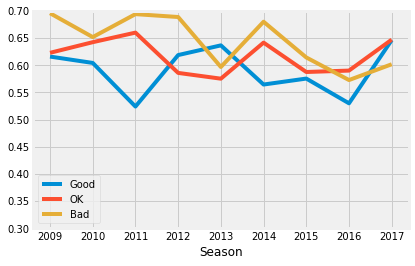

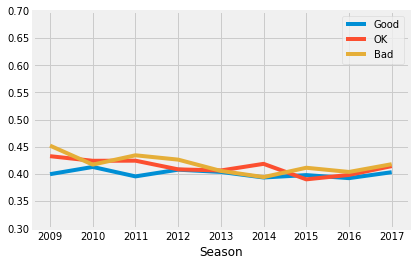

In [29]:
# Ommitting 2018 because we do not have a full season's worth of data for it.
seasons = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

import matplotlib.style as style
style.use('fivethirtyeight')

# Run plays as % of total plays general formula
def run_play_breakdown(df, comfy_lead):
    team_list = []
    for season in seasons:
        home_runs = df.loc[(df.season == season) & (df.home_comfy_lead == comfy_lead), 'home_runs'].sum()
        away_runs = df.loc[(df.season == season) & (df.away_comfy_lead == comfy_lead), 'away_runs'].sum()
        home_passes = df.loc[(df.season == season) & (df.home_comfy_lead == comfy_lead), 'home_passes'].sum()
        away_passes = df.loc[(df.season == season) & (df.away_comfy_lead == comfy_lead), 'away_passes'].sum()
        total_runs = home_runs + away_runs
        total_plays = home_runs + away_runs + home_passes + away_passes
        total_run_perc = total_runs / total_plays
        team_list.append(total_run_perc)
    return team_list


# Run play % when the team has a comfortable lead.
good_teams_comfylead = run_play_breakdown(good, 1)
ok_teams_comfylead = run_play_breakdown(ok, 1)
bad_teams_comfylead = run_play_breakdown(bad, 1)

%matplotlib inline

runs_comfylead = pd.DataFrame(
    {   "Season": seasons,
        "Good": good_teams_comfylead,
        "OK": ok_teams_comfylead,
        "Bad": bad_teams_comfylead
    })

rcl_percents = runs_comfylead.iloc[0,1:4]

runs_comfylead_graph = runs_comfylead.plot(x = 'Season', y = rcl_percents.index)
runs_comfylead_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
runs_comfylead_graph.set_ylim(.3, .7)


# Run play % when the team does NOT have a comfortable lead.
good_teams_no_comfylead = run_play_breakdown(good, 0)
ok_teams_no_comfylead = run_play_breakdown(ok, 0)
bad_teams_no_comfylead = run_play_breakdown(bad, 0)

runs_no_comfylead = pd.DataFrame(
    {
        "Season": seasons,
        "Good": good_teams_no_comfylead,
        "OK": ok_teams_no_comfylead,
        "Bad": bad_teams_no_comfylead
    })

rncl_percents = runs_no_comfylead.iloc[0,1:4]

runs_no_comfylead_graph = runs_no_comfylead.plot(x = 'Season', y = rncl_percents.index)
runs_no_comfylead_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
runs_no_comfylead_graph.set_ylim(.3,.7)

We can see that all teams call runs on roughly 40% of their plays when they do not have a substantial lead and run more often (about 60% of plays) when they do.

### Yardage

(0, 40)

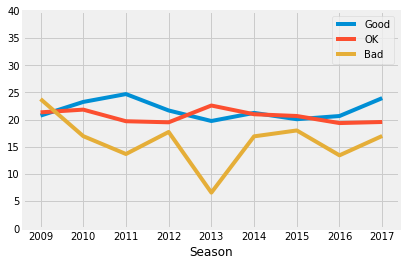

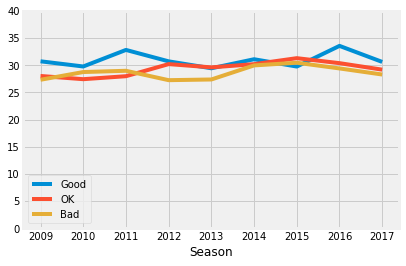

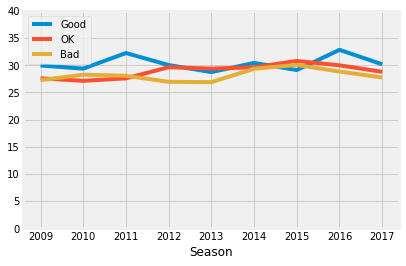

In [30]:
# Yards per drive general formula
def yards_breakdown(df, yards, drives):
    team_list = []
    for season in seasons:
        home_yards = df.loc[(df.season == season) & (df.EOG==1), 'home' + yards].sum()
        away_yards = df.loc[(df.season == season) & (df.EOG==1), 'away' + yards].sum()
        home_drives = df.loc[(df.season == season) & (df.EOG==1), 'home' + drives].sum()
        away_drives = df.loc[(df.season == season) & (df.EOG==1), 'away' + drives].sum()
        total_yards = home_yards + away_yards
        total_drives = home_drives + away_drives
        yards_per_drive = total_yards / total_drives
        team_list.append(yards_per_drive)
    return team_list


# Yards per drive when the team has a comfortable lead.
good_teams_ypd_cl = yards_breakdown(good, '_yards_wcl_final', '_drives_wcl_final')
ok_teams_ypd_cl = yards_breakdown(ok, '_yards_wcl_final', '_drives_wcl_final')
bad_teams_ypd_cl = yards_breakdown(bad, '_yards_wcl_final', '_drives_wcl_final')

%matplotlib inline

yards_cl = pd.DataFrame(
    {   "Season": seasons,
        "Good": good_teams_ypd_cl,
        "OK": ok_teams_ypd_cl,
        "Bad": bad_teams_ypd_cl
    })

yards_cl_percents = yards_cl.iloc[0,1:4]

yards_cl_graph = yards_cl.plot("Season", yards_cl_percents.index)
yards_cl_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
yards_cl_graph.set_ylim(0, 40)


# Yards per drive when the team does NOT have a comfortable lead.
good_teams_ypd_nocl = yards_breakdown(good, '_yards_wocl_final', '_drives_wocl_final')
ok_teams_ypd_nocl = yards_breakdown(ok, '_yards_wocl_final', '_drives_wocl_final')
bad_teams_ypd_nocl = yards_breakdown(bad, '_yards_wocl_final', '_drives_wocl_final')

yards_no_comfylead = pd.DataFrame(
    {   "Season": seasons,
        "Good": good_teams_ypd_nocl,
        "OK": ok_teams_ypd_nocl,
        "Bad": bad_teams_ypd_nocl
    })

yards_no_comfylead_percents = yards_no_comfylead.iloc[0,1:4]

yards_no_comfylead_graph = yards_no_comfylead.plot("Season", yards_no_comfylead_percents.index)
yards_no_comfylead_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
yards_no_comfylead_graph.set_ylim(0, 40)


# Yards per drive overall
good_teams_ypd = yards_breakdown(good, '_yards_final', '_drives_final')
ok_teams_ypd = yards_breakdown(ok, '_yards_final', '_drives_final')
bad_teams_ypd = yards_breakdown(bad, '_yards_final', '_drives_final')

yards = pd.DataFrame(
    {   "Season": seasons,
        "Good": good_teams_ypd,
        "OK": ok_teams_ypd,
        "Bad": bad_teams_ypd
    })

yards_percents = yards.iloc[0,1:4]

yards_graph = yards.plot("Season", yards_percents.index)
yards_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
yards_graph.set_ylim(0, 40)

While there is some separation in overall yards per drive between good teams and bad teams, when a comfortable lead is established, good teams are substantially better at accumulating more yards per drive. While some long-yardage drives can actually be very brief (e.g. drives that result in quick scores on singular explosive plays), they are generally suggestive of longer time of possession.

### Plays per Drive

(2, 6)

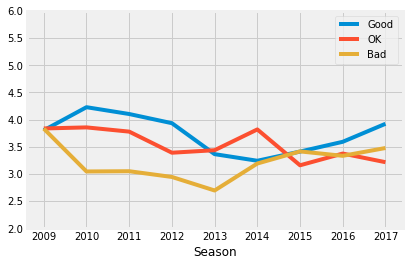

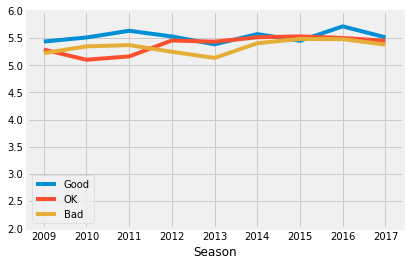

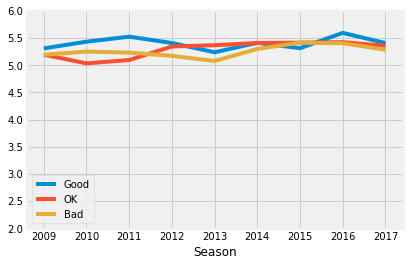

In [31]:
# Plays per drive general formula
def ppd_breakdown(df, plays, drives):
    team_list = []
    for season in seasons:
        home_plays = df.loc[(df.season == season) & (df.EOG==1), 'home' + plays].sum()
        away_plays = df.loc[(df.season == season) & (df.EOG==1), 'away' + plays].sum()
        home_drives = df.loc[(df.season == season) & (df.EOG==1), 'home' + drives].sum()
        away_drives = df.loc[(df.season == season) & (df.EOG==1), 'away' + drives].sum()
        total_plays = home_plays + away_plays
        total_drives = home_drives + away_drives
        total_ppd = total_plays / total_drives
        team_list.append(total_ppd)
    return team_list

%matplotlib inline


# Plays per drive when the team has a comfortable lead
good_teams_ppd_cl = ppd_breakdown(good, '_combined_plays_wcl_final', '_drives_wcl_final')
ok_teams_ppd_cl = ppd_breakdown(ok, '_combined_plays_wcl_final', '_drives_wcl_final')
bad_teams_ppd_cl = ppd_breakdown(bad, '_combined_plays_wcl_final', '_drives_wcl_final')

ppd_cl = pd.DataFrame(
    {   "Season": seasons,
        "Good": good_teams_ppd_cl,
        "OK": ok_teams_ppd_cl,
        "Bad": bad_teams_ppd_cl
    })


ppdcl_percents = ppd_cl.iloc[0,1:4]

ppd_cl_graph = ppd_cl.plot("Season", ppdcl_percents.index)
ppd_cl_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
ppd_cl_graph.set_ylim(2, 6)


# Plays per drive when the team does NOT have a comfortable lead
good_teams_ppd_no_cl = ppd_breakdown(good, '_combined_plays_wocl_final', '_drives_wocl_final')
ok_teams_ppd_no_cl = ppd_breakdown(ok, '_combined_plays_wocl_final', '_drives_wocl_final')
bad_teams_ppd_no_cl = ppd_breakdown(bad, '_combined_plays_wocl_final', '_drives_wocl_final')

ppd_no_cl = pd.DataFrame(
    {   "Season": seasons,
        "Good": good_teams_ppd_no_cl,
        "OK": ok_teams_ppd_no_cl,
        "Bad": bad_teams_ppd_no_cl
    })

ppdncl_percents = ppd_no_cl.iloc[0,1:4]

ppd_no_cl_graph = ppd_no_cl.plot("Season", ppdncl_percents.index)
ppd_no_cl_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
ppd_no_cl_graph.set_ylim(2,6)


# Plays per drive overall
good_teams_ppd = ppd_breakdown(good, '_combined_plays_final', '_drives_final')
ok_teams_ppd = ppd_breakdown(ok, '_combined_plays_final', '_drives_final')
bad_teams_ppd = ppd_breakdown(bad, '_combined_plays_final', '_drives_final')

ppd = pd.DataFrame(
    {
        "Season": seasons,
        "Good": good_teams_ppd,
        "OK": ok_teams_ppd,
        "Bad": bad_teams_ppd
    })

ppd_percents = ppd.iloc[0,1:4]

ppd_graph = ppd.plot('Season', ppd_percents.index)
ppd_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
ppd_graph.set_ylim(2,6)

Again, there is some separation here with plays per drive between good teams and bad teams, and significantly more separation in drives with a comfortable lead established. We can also see that OK teams occasionally "punch above their weight" and hit plays per drive levels commensurate with those of good teams.

Good teams consistently execute 1 more play per drive than bad teams when they have comfortable leads. A drive consisting of more plays will typically "drain the clock" and leave the opposition with less time to mount a comeback.

### TOP per Drive

(90, 160)

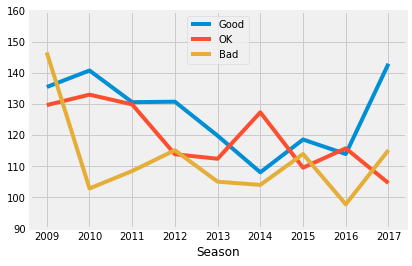

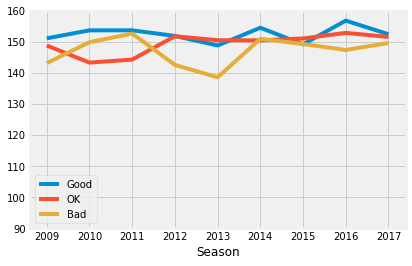

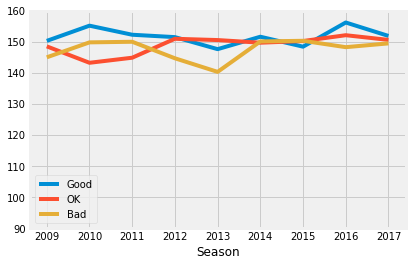

In [32]:
# TOP per drive general formula
def TOP_breakdown(df, TOP, drives):
    team_list = []
    for season in seasons:
        home_TOP = df.loc[(df.season == season) & (df.EOG==1), 'home' + TOP].sum()
        away_TOP = df.loc[(df.season == season) & (df.EOG==1), 'away' + TOP].sum()
        home_drives = df.loc[(df.season == season) & (df.EOG==1), 'home' + drives].sum()
        away_drives = df.loc[(df.season == season) & (df.EOG==1), 'away' + drives].sum()
        total_TOP = home_TOP + away_TOP
        total_drives = home_drives + away_drives
        total_TOP_pd = total_TOP / total_drives
        team_list.append(total_TOP_pd)
    return team_list


# TOP per drive when the team has a comfortable lead
good_teams_TOP_pd_cl = TOP_breakdown(good, '_TOP_wcl_final', '_drives_wcl_final')
ok_teams_TOP_pd_cl = TOP_breakdown(ok, '_TOP_wcl_final', '_drives_wcl_final')
bad_teams_TOP_pd_cl = TOP_breakdown(bad, '_TOP_wcl_final', '_drives_wcl_final')

TOP_cl = pd.DataFrame(
    {
        "Season": seasons,
        "Good": good_teams_TOP_pd_cl,
        "OK": ok_teams_TOP_pd_cl,        
        "Bad": bad_teams_TOP_pd_cl
    })

TOP_cl_percents = TOP_cl.iloc[0,1:4]

TOP_cl_graph = TOP_cl.plot('Season', TOP_cl_percents.index)
TOP_cl_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
TOP_cl_graph.set_ylim(90,160)


# TOP per drive when the team does NOT have a comfortable lead
good_teams_TOP_pd_no_cl = TOP_breakdown(good, '_TOP_wocl_final', '_drives_wocl_final')
ok_teams_TOP_pd_no_cl = TOP_breakdown(ok, '_TOP_wocl_final', '_drives_wocl_final')
bad_teams_TOP_pd_no_cl = TOP_breakdown(bad, '_TOP_wocl_final', '_drives_wocl_final')

TOP_no_cl = pd.DataFrame(
    {
        "Season": seasons,
        "Good": good_teams_TOP_pd_no_cl,
        "OK": ok_teams_TOP_pd_no_cl,        
        "Bad": bad_teams_TOP_pd_no_cl
    })

TOP_no_cl_percents = TOP_no_cl.iloc[0,1:4]

TOP_no_cl_graph = TOP_no_cl.plot('Season', TOP_no_cl_percents.index)
TOP_no_cl_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
TOP_no_cl_graph.set_ylim(90,160)


# TOP per drive overall
good_teams_TOP_pd = TOP_breakdown(good, '_TOP_final', '_drives_final')
ok_teams_TOP_pd = TOP_breakdown(ok, '_TOP_final', '_drives_final')
bad_teams_TOP_pd = TOP_breakdown(bad, '_TOP_final', '_drives_final')

TOP = pd.DataFrame(
    {
        "Season": seasons,  
        "Good": good_teams_TOP_pd,
        "OK": ok_teams_TOP_pd,      
        "Bad": bad_teams_TOP_pd
    })

TOP_percent = TOP.iloc[0,1:4]

TOP_graph = TOP.plot('Season', TOP_percent.index)
TOP_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
TOP_graph.set_ylim(90,160)

This is the most on-the-nose indicator of ball control and a great suggester of offensive efficiency. Good teams overall hold onto the ball longer than bad teams by ~7 seconds per drive. When a comfortable lead is established, good teams are dramatically better at draining the clock. Bad teams surrender the ball faster and blow comfortable leads.

### Points per Drive

(1.5, 2.5)

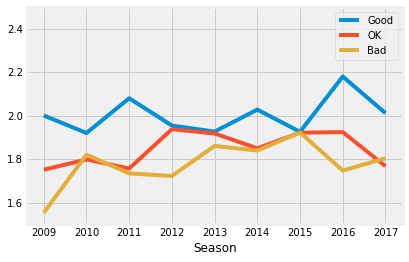

In [33]:
# Points per drive general formula
def score_breakdown(df, score, drives):
    team_list = []
    for season in seasons:
        home_score = df.loc[(df.season == season) & (df.EOG==1), 'home' + score].sum()
        away_score = df.loc[(df.season == season) & (df.EOG==1), 'away' + score].sum()
        home_drives = df.loc[(df.season == season) & (df.EOG==1), 'home' + drives].sum()
        away_drives = df.loc[(df.season == season) & (df.EOG==1), 'away' + drives].sum()
        total_score = home_score + away_score
        total_drives = home_drives + away_drives
        total_score_pd = total_score / total_drives
        team_list.append(total_score_pd)
    return team_list


# Points per drive overall
good_teams_score_pd = score_breakdown(good, '_score_final', '_drives_final')
ok_teams_score_pd = score_breakdown(ok, '_score_final', '_drives_final')
bad_teams_score_pd = score_breakdown(bad, '_score_final', '_drives_final')

score = pd.DataFrame(
    {
        "Season": seasons,
        "Good": good_teams_score_pd,
        "OK": ok_teams_score_pd,
        "Bad": bad_teams_score_pd
    })

score_percents = score.iloc[0,1:4]

score_graph = score.plot('Season', score_percents.index)
score_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)
score_graph.set_ylim(1.5,2.5)

Naturally, one would expect a team that wins more to score more points per drive. This expectation holds true in our graph.

# LOGISTIC REGRESSION
Now let's perform logistic regression on our metrics to see what we find.

In [34]:
nfl_eog = nfl[nfl['EOG']==1]

### Time of Possession per Drive

/home/jeesuk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/jeesuk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


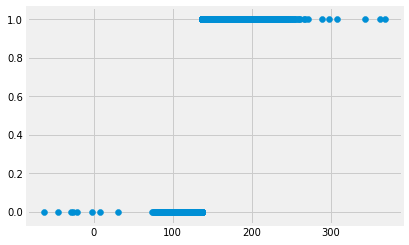

/home/jeesuk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/jeesuk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


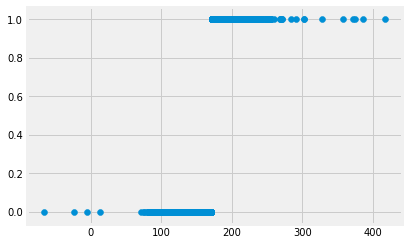

In [35]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

nfl_eog['home_TOP_pd'] = nfl_eog['home_TOP_final'] / nfl_eog['home_drives_final']
nfl_eog['home_TOP_pd'] = nfl_eog['home_TOP_pd'].fillna(0)

logistic_model = LogisticRegression()
logistic_model.fit(nfl_eog[['home_TOP_pd']], nfl_eog['home_gw'])
home_TOP_labels = logistic_model.predict(nfl_eog[['home_TOP_pd']])
plt.scatter(nfl_eog['home_TOP_pd'], home_TOP_labels)
plt.show()

nfl_eog['away_TOP_pd'] = nfl_eog['away_TOP_final'] / nfl_eog['away_drives_final']
nfl_eog['away_TOP_pd'] = nfl_eog['away_TOP_pd'].fillna(0)

logistic_model = LogisticRegression()
logistic_model.fit(nfl_eog[['away_TOP_pd']], nfl_eog['away_gw'])
away_TOP_labels = logistic_model.predict(nfl_eog[['away_TOP_pd']])
plt.scatter(nfl_eog['away_TOP_pd'], away_TOP_labels)
plt.show()

### Plays per Drive

/home/jeesuk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


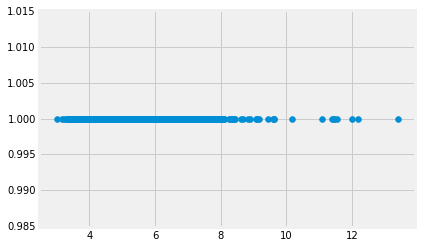

In [41]:
nfl_eog['home_combined_plays_pd'] = nfl_eog['home_combined_plays_final'] / nfl_eog['home_drives_final']

logistic_model = LogisticRegression()
logistic_model.fit(nfl_eog[['home_combined_plays_pd']], nfl_eog['home_gw'])
home_combined_plays_labels = logistic_model.predict(nfl_eog[['home_combined_plays_pd']])
plt.scatter(nfl_eog['home_combined_plays_pd'], home_combined_plays_labels)
plt.show()

#### Home Team Plays per Drive and Winning
Interestingly, regardless of the plays per drive average, our model predicts that the home team will win. Let's look at the probabilities to see why this is the case.

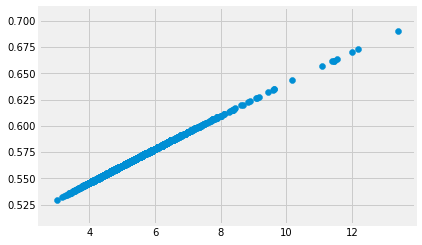

In [46]:
logistic_model = LogisticRegression()
logistic_model.fit(nfl_eog[['home_combined_plays_pd']], nfl_eog['home_gw'])
home_combined_plays_pred_probs = logistic_model.predict_proba(nfl_eog[['home_combined_plays_pd']])
plt.scatter(nfl_eog['home_combined_plays_pd'], home_combined_plays_pred_probs[:,1])

Even a sub-4 plays per drive average yields a 52.5% probability of victory. Let's look at some slices of the the `nfl_eog` dataframe to confirm this.

In [49]:
# Home team registers less than or equal to 4 plays per drive on average
print(nfl_eog.loc[(nfl_eog.home_gw==1) & (nfl_eog.home_combined_plays_pd<=4), ['game_id','home_team','away_team', 'game_winner',
         'home_combined_plays_final', 'home_drives_final', 'home_combined_plays_pd']].shape)
print(nfl_eog.loc[(nfl_eog.home_gw==0) & (nfl_eog.home_combined_plays_pd<=4), ['game_id','home_team','away_team', 'game_winner',
         'home_combined_plays_final', 'home_drives_final', 'home_combined_plays_pd']].shape)

# Home team registers less than or equal to 5 plays per drive on average
print(nfl_eog.loc[(nfl_eog.home_gw==1) & (nfl_eog.home_combined_plays_pd<=5), ['game_id','home_team','away_team', 'game_winner',
         'home_combined_plays_final', 'home_drives_final', 'home_combined_plays_pd']].shape)
print(nfl_eog.loc[(nfl_eog.home_gw==0) & (nfl_eog.home_combined_plays_pd<=5), ['game_id','home_team','away_team', 'game_winner',
         'home_combined_plays_final', 'home_drives_final', 'home_combined_plays_pd']].shape)

(55, 7)
(62, 7)
(504, 7)
(396, 7)


#### Home Field Advantage?
From this look at the breakdown of home team victories despite limited plays per drive, home field advantage is truly pronounced. How exactly this is manifesting on the field is unclear, but possible factors include:

- Quick offensive strikes on some drives for the home team
- Suffocating home team defense
- Turnovers forced or great special teams plays that result in the home field getting favorable field position to begin their drives

/home/jeesuk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


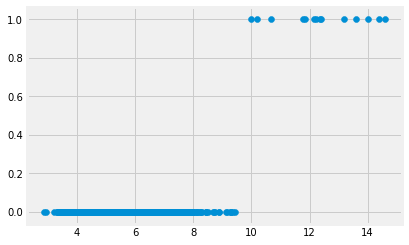

In [50]:
nfl_eog['away_combined_plays_pd'] = nfl_eog['away_combined_plays_final'] / nfl_eog['away_drives_final']

logistic_model = LogisticRegression()
logistic_model.fit(nfl_eog[['away_combined_plays_pd']], nfl_eog['away_gw'])
away_combined_plays_labels = logistic_model.predict(nfl_eog[['away_combined_plays_pd']])
plt.scatter(nfl_eog['away_combined_plays_pd'], away_combined_plays_labels)
plt.show()

#### Hostile Territory
The away team, however, must generate at least 9 plays per drive on average in order to have greater than 50% probability of victory. Possible factors include those mentioned above that contribute to home field advantage, in addition to a noisy home team crowd that makes it extremely difficult for the away team offense to communicate. This can result in mistakes that render plays ineffective.

## Yards per Drive

/home/jeesuk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


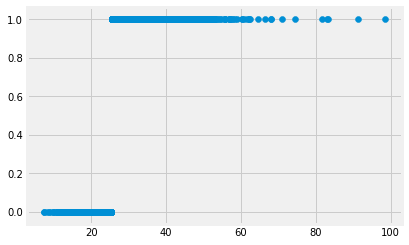

/home/jeesuk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


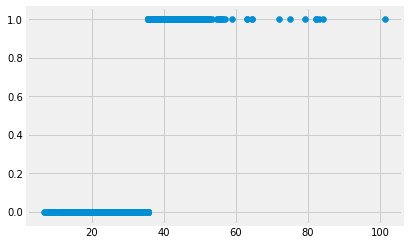

In [51]:
nfl_eog['home_yards_pd'] = nfl_eog['home_yards_final'] / nfl_eog['home_drives_final']

logistic_model = LogisticRegression()
logistic_model.fit(nfl_eog[['home_yards_pd']], nfl_eog['home_gw'])
home_yards_labels = logistic_model.predict(nfl_eog[['home_yards_pd']])
plt.scatter(nfl_eog['home_yards_pd'], home_yards_labels)
plt.show()

nfl_eog['away_yards_pd'] = nfl_eog['away_yards_final'] / nfl_eog['away_drives_final']

logistic_model = LogisticRegression()
logistic_model.fit(nfl_eog[['away_yards_pd']], nfl_eog['away_gw'])
away_yards_labels = logistic_model.predict(nfl_eog[['away_yards_pd']])
plt.scatter(nfl_eog['away_yards_pd'], away_yards_labels)
plt.show()

# CONCLUSION
Looking at the different performance tiers of teams, there is some separation between the good and the bad teams for each offensive efficiency metric. However, in situations when a team has a comfortable lead, the good teams control the ball much more effectively. They do not blow their leads.

### Other Things to Explore
- How a team that had a comfortable lead performs after they lose it and whether that team ultiamtely wins. A team with a 20-point lead at the start of the 4th quarter may allow the opponent to shrink the margin to 8 points near the end of the game. But at that point, the trailing team's efforts are often "too little, too late." Typically, there is insufficient time for the trailing team to win.
- Home field advantage. The plays per drive average of the home team is a very illuminating finding.
- Schemes and formations, though that would require a more robust dataset.